In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# Set dataset path and categories
dataset_path = r"E:\Textile Defect\junk\fabric defect\Data Set"
categories = ["Hole", "Horizontal Line", "Isolated Defect", "Needle Lines", "Vertical Line"]

In [3]:
# Load and preprocess data
# data_generator = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.3,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# Data augmentation and preprocessing
data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical_flip
    brightness_range=[0.8, 1.2],  # Added brightness_range
    channel_shift_range=0.2,  # Added channel_shift_range
    fill_mode='nearest'
)

train_data = data_generator.flow_from_directory(dataset_path, target_size=(224, 224), classes=categories, subset="training")
val_data = data_generator.flow_from_directory(dataset_path, target_size=(224, 224), classes=categories, subset="validation")

Found 468 images belonging to 5 classes.
Found 198 images belonging to 5 classes.


In [4]:
# Model architecture
def create_cnn_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),  # Added extra Conv2D layer
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),  # Increased number of neurons
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  # Adjusted learning rate
    return model


In [5]:
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
def create_inception_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
def unfreeze_layers(model, num_unfrozen_layers):
    for layer in model.layers[:-num_unfrozen_layers]:
        layer.trainable = False
    for layer in model.layers[-num_unfrozen_layers:]:
        layer.trainable = True

def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    unfreeze_layers(base_model, 10)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_inception_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    unfreeze_layers(base_model, 10)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [8]:
# Train and evaluate models
models = {
    "CNN": create_cnn_model(),
    "ResNet50": create_resnet_model(),
    "InceptionV3": create_inception_model()
}

In [9]:
# Training with callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)


In [10]:
# for model_name, model in models.items():
#     print(f"Training {model_name}...")
#     model.fit(train_data, epochs=15, validation_data=val_data, verbose=1)  # Increased the number of epochs

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(train_data, epochs=15, validation_data=val_data, verbose=1, callbacks=[early_stopping, model_checkpoint])  # Added callbacks

Training CNN...
Epoch 1/15
15/15 [==============================] - 232s 15s/step - loss: 1.5048 - accuracy: 0.3098 - val_loss: 1.3795 - val_accuracy: 0.4192
Epoch 2/15
15/15 [==============================] - 202s 14s/step - loss: 1.3017 - accuracy: 0.4744 - val_loss: 1.2008 - val_accuracy: 0.4798
Epoch 3/15
15/15 [==============================] - 206s 14s/step - loss: 1.1323 - accuracy: 0.5256 - val_loss: 1.0748 - val_accuracy: 0.5657
Epoch 4/15
15/15 [==============================] - 195s 13s/step - loss: 1.0684 - accuracy: 0.5321 - val_loss: 1.0383 - val_accuracy: 0.5707
Epoch 5/15
15/15 [==============================] - 185s 12s/step - loss: 1.0008 - accuracy: 0.5256 - val_loss: 1.0497 - val_accuracy: 0.5404
Epoch 6/15
15/15 [==============================] - 187s 12s/step - loss: 0.9811 - accuracy: 0.5833 - val_loss: 1.0090 - val_accuracy: 0.5404
Epoch 7/15
15/15 [==============================] - 188s 13s/step - loss: 0.9856 - accuracy: 0.5449 - val_loss: 0.9798 - val_accurac

In [11]:
# Evaluate model
print(f"Evaluating {model_name}...")
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

accuracy = accuracy_score(y_true, y_pred_classes) * 100
f1 = f1_score(y_true, y_pred_classes, average='weighted') * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"F1 Score: {f1:.2f}%")

Evaluating InceptionV3...
7/7 [==============================] - 92s 11s/step
Accuracy: 17.17%
F1 Score: 17.05%


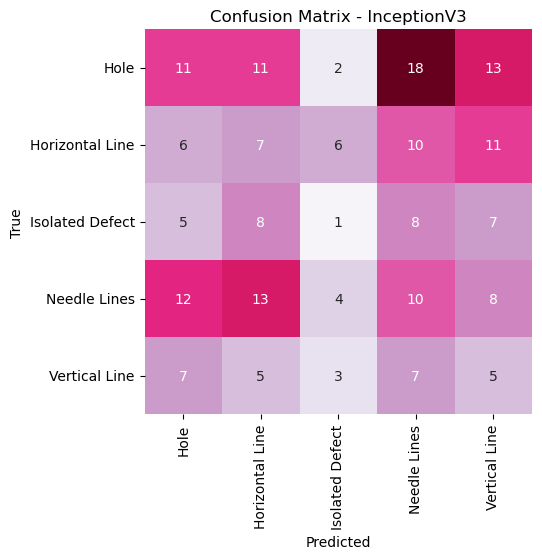

In [12]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd", cbar=False, xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {model_name}")
plt.show()
